In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from func import OR,heatplot,misorientation,ipfread,classplot,ipfplot
from Class import Data,Cluster,Dataset
import sys
import os
import cv2
import pandas as pd
from unet import UNet
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import matplotlib.patches as patches

In [4]:
class Dataset():
    def __init__(self,bef,aft,im,im_,dates):
        self.bef=bef
        self.aft=aft
        self.im=im
        self.im_=im_
        self.dates=dates
def create_dataset(root="data/train/"):
    bef=[]
    aft=[]
    im=[]
    im_=[]
    dates=[]
    for date in os.listdir(root):
        path=root+date+"/before/"
        path_=root+date+"/after/"
        bef.append(Data(path));aft.append(Data(path_))
        im.append(ipfread(path)/255.);im_.append(ipfread(path_)/255.)
        dates.append(date)
    return Dataset(bef,aft,im,im_,dates)

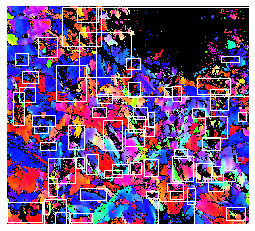

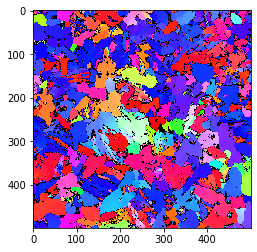

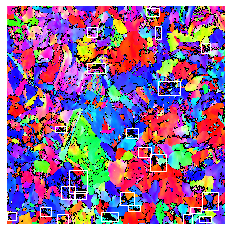

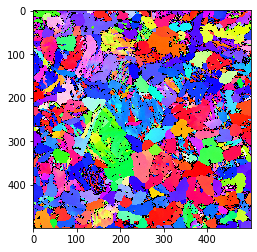

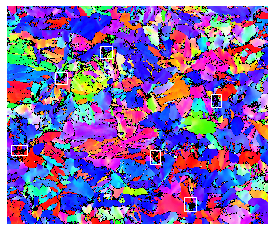

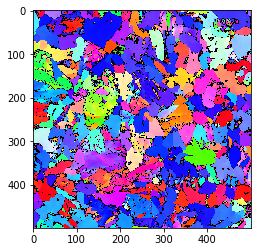

In [5]:
def prepare_location(option):
    dataset=create_dataset("data/{option}/".format(option=option))
    for index in range(len(dataset.aft)):
        phase=1-dataset.aft[index].data["Phase"]
        cv2.imwrite("output/phase_{option}_{date}.png".format(option=option,date=dataset.dates[index]),(255*(1-phase)).astype("int"))
        cmap=np.zeros([phase.shape[0],phase.shape[1]]).astype("int")
        cluster=dict()
        ind = 1
        for i in range(phase.shape[0]):
            for j in range(phase.shape[1]):
                if phase[i,j]==1:
                    if j>0 and phase[i,j-1]==1:
                        cmap[i,j]=cmap[i,j-1]
                        cluster[cmap[i,j]].add(i,j)
                        if i>0 and phase[i-1,j]==1 and cmap[i,j]!=cmap[i-1,j]:
                            cluster[cmap[i,j]].addn(cmap[i-1,j])
                            cluster[cmap[i-1,j]].addn(cmap[i,j])                    
                    elif i>0 and phase[i-1,j]==1:
                        cmap[i,j]=cmap[i-1,j]
                        cluster[cmap[i,j]].add(i,j)
                    else:
                        cmap[i,j]=ind
                        cluster[ind]=Cluster(ind,i,j)
                        ind+=1   
        for key in range(1,ind):
            if key in cluster:
                for neigh in cluster[key].neigh.copy():
                    cluster[key].merge(neigh,cluster)
        crack=[]
        phase_aft=np.ones([phase.shape[0],phase.shape[1]])
        for key in range(1,ind):
            if key in cluster:
                if cluster[key].num>200:
                    for (i,j) in cluster[key].pixels:
                        phase_aft[i,j]=0
                    crack.append(key)
        cv2.imwrite("output/phase_aft_{option}_{date}.png".format(option=option,date=dataset.dates[index]),(255*phase_aft).astype("int"))
        crack_rec = []
        for id in crack:
            sample=np.array(list(cluster[id].pixels))
            top,left=np.min(sample,axis=0)
            bot,right=np.max(sample,axis=0)
            crack_rec.append([top,bot,left,right])
        h=w=50
        im = dataset.im[index]
        im_ = dataset.im_[index]
        fig,ax = plt.subplots(1)
        ax.axis('off')
        ax.imshow(im_[:,:,6:][...,[2,1,0]])
        corner_d = []
#         corner_b = []
        # w0,h0,w,h
        for i in range(len(crack_rec)):
            top,bot,left,right = crack_rec[i]
#             top = (top+bot)//2-25
#             left = (left+right)//2-25
            try:
#                 p,min_val=match(L2,im_[top:top+h,left:left+w],im,top,left)
#                 if min_val<5000 and p[0]>0 and p[1]>0 and p[0]+h<im.shape[0] and p[1]+w<im.shape[1]:
                rect = patches.Rectangle((left,top),right-left,bot-top,linewidth=1,edgecolor='w',facecolor='none')
                ax.add_patch(rect)
                corner_d.append([top,left])
                corner_b.append(p)
            except:
                pass
        plt.savefig("output/{option}_{date}d.png".format(option=option,date=dataset.dates[index]),dpi=600,bbox_inches='tight',pad_inches=0)
        plt.show()
        fig,ax = plt.subplots(1)
        ax.imshow(dataset.im[index][:,:,6:][...,[2,1,0]])
        cv2.imwrite("output/{option}_{date}b.png".format(option=option,date=dataset.dates[index]),255*dataset.im[index][:,:,6:])
#         plt.savefig("output/{option}{index}b.png".format(option=option,index=index),dpi=600)
        # w0,h0,w,h
#         for i in range(len(corner_b)):
#             top,left = corner_b[i]
#             rect = patches.Rectangle((left,top),50,50,linewidth=1,edgecolor='w',facecolor='none')
#             ax.add_patch(rect)
#         plt.savefig("output/{option}{index}b.png".format(option=option,index=index),dpi=600)
#         plt.show()
#         np.save("output/{option}_corner_{index}.npy".format(option=option,index=index),[corner_b,corner_d])
# prepare_location("train")
# prepare_location("test")
prepare_location("980")